# Consumer Sentiment Analysis: Using Federal Reserve Data to Predict Consumer Sentiment

**MADS Capstone Project - Rate Hike Rangers** - Paul Stotts (pdstotts), Dave Norine (dnorine), Ali Alrubaiee (aalrubai)



Consumer sentiment—how optimistic or pessimistic people feel about the economy—is a powerful predictor of economic activity. The University of Michigan Consumer Sentiment Index (UMCSENT) has tracked this metric since 1952, becoming one of the most closely watched economic indicators.

### Key Questions Addressed Here:

1. **What drives consumer sentiment?** Which economic indicators have the strongest influence?
2. **How quickly do changes propagate?** What are the lag structures between economic events and sentiment shifts?
3. **Can we forecast sentiment accurately?** How well can we predict future sentiment using current data?
4. **What are the downstream effects?** How does sentiment influence actual economic behavior?

<a id='setup'></a>
## Setup & Imports

In [1]:
# Import libraries
import os
import warnings
import json
import time
import pickle
import hashlib
from datetime import datetime
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from scipy import stats
from fredapi import Fred
import shap

# Environment variables
from dotenv import load_dotenv
load_dotenv()

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')
warnings.filterwarnings('ignore')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create output directories
output_dirs = [
    'outputs/data',
    'outputs/models',
    'outputs/results',
    'outputs/visualizations',
    'outputs/cache'
]

for dir_path in output_dirs:
    os.makedirs(dir_path, exist_ok=True)

print(f"Working directory: {os.getcwd()}")


Working directory: /Users/pdsmbp/Library/Mobile Documents/com~apple~CloudDocs/Projects/MADS/MADS_Capstone


<a id='data-collection'></a>
## Data Collection

We'll gather a comprehensive set of economic indicators from the Federal Reserve Economic Data (FRED) API to understand what drives consumer sentiment.

In [2]:
# Initialize FRED API
fred_api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=fred_api_key)

In [3]:
# Define comprehensive indicator set (44 indicators)
comprehensive_indicators = {
    # Target variable
    'UMCSENT': 'Consumer Sentiment Index',
    
    # Core Economic Indicators
    'CPIAUCSL': 'Consumer Price Index',
    'UNRATE': 'Unemployment Rate',
    'GASREGW': 'Regular Gasoline Prices',
    'RSAFS': 'Retail Sales',
    'DSPIC96': 'Real Disposable Personal Income',
    'AHETPI': 'Average Hourly Earnings',
    'CPIUFDSL': 'CPI for Food',
    'CUSR0000SEHA': 'CPI for Shelter',
    'HOUST': 'Housing Starts',
    'SP500': 'S&P 500 Index',
    'PSAVERT': 'Personal Savings Rate',
    'TCMDO': 'Total Consumer Debt',
    'M1SL': 'M1 Money Supply',
    'INDPRO': 'Industrial Production Index',
    'CSUSHPINSA': 'Case-Shiller Home Price Index',
    'PCE': 'Personal Consumption Expenditures',
    'FEDFUNDS': 'Federal Funds Rate',
    'CC4WSA': 'Consumer Credit',
    'VIXCLS': 'VIX Volatility Index',
    'GS10': '10-Year Treasury Yield',
    'FMNHSHPSIUS': 'Home Purchase Sentiment',
    'HPIPONM226S': 'FHFA House Price Index',
    'PERMIT': 'Building Permits',
    'MORTGAGE30US': '30-Year Mortgage Rate',
    'DGORDER': 'Durable Goods Orders',
    'BUSINV': 'Business Inventories',
    
    # Additional Leading Indicators Tested
    'ICSA': 'Initial Jobless Claims',
    'PAYEMS': 'Nonfarm Payrolls',
    'CIVPART': 'Labor Force Participation Rate',
    'U6RATE': 'Underemployment Rate',
    'T10Y2Y': '10Y-2Y Treasury Spread',
    'T10Y3M': '10Y-3M Treasury Spread',
    'BAMLH0A0HYM2': 'High Yield Bond Spread',
    'TEDRATE': 'TED Spread',
    'ANFCI': 'Chicago Fed Financial Conditions',
    'MICH': 'Consumer Expectations Index',
    'CPILFESL': 'Core CPI',
    'NEWORDER': 'Manufacturers New Orders',
    'AWHMAN': 'Avg Weekly Hours - Manufacturing',
    'DCOILWTICO': 'WTI Crude Oil Prices',
    'DEXUSEU': 'USD/EUR Exchange Rate',
    'USEPUINDXD': 'Economic Policy Uncertainty'
}

# Core indicators for forecasting
core_indicators = {
    'UMCSENT': 'Consumer Sentiment Index',
    'CPIAUCSL': 'Consumer Price Index',
    'UNRATE': 'Unemployment Rate',
    'T10Y3M': '10Y-3M Treasury Spread',
    'GASREGW': 'Regular Gasoline Prices'
}

In [4]:
# Caching functions
cache_dir = Path('outputs/cache')

def get_cache_key(code, start_date, end_date):
    key_str = f"{code}_{start_date}_{end_date}"
    return hashlib.md5(key_str.encode()).hexdigest()

def load_from_cache(code, start_date, end_date):
    cache_key = get_cache_key(code, start_date, end_date)
    cache_file = cache_dir / f"{cache_key}.pkl"
    
    if cache_file.exists():
        try:
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        except:
            pass
    return None

def save_to_cache(code, start_date, end_date, data):
    cache_key = get_cache_key(code, start_date, end_date)
    cache_file = cache_dir / f"{cache_key}.pkl"
    
    try:
        with open(cache_file, 'wb') as f:
            pickle.dump(data, f)
    except:
        pass

def fetch_with_exponential_backoff(fred, code, start_date, end_date, max_retries=5):
    base_delay = 1
    
    for attempt in range(max_retries):
        try:
            series = fred.get_series(code, observation_start=start_date, observation_end=end_date)
            return series
        except Exception as e:
            if "429" in str(e) or "Too Many Requests" in str(e):
                if attempt < max_retries - 1:
                    delay = base_delay * (2 ** attempt)
                    time.sleep(delay)
                else:
                    raise e
            else:
                raise e
    
    return None

In [5]:
# Getcomprehensive dataset
def fetch_indicators(indicator_dict, start_date='1990-01-01', end_date='2025-05-31'):
    data_dict = {}
    fetch_errors = []
    cache_hits = 0
    api_calls = 0
    
    start_time = time.time()
    print(f"Fetching {len(indicator_dict)} indicators...")
    
    for i, (code, description) in enumerate(indicator_dict.items()):
        print(f"[{i+1:2d}/{len(indicator_dict)}] {code:15s}: {description[:30]:30s}...", end=' ')
        
        cached_data = load_from_cache(code, start_date, end_date)
        if cached_data is not None:
            data_dict[code] = cached_data
            cache_hits += 1
            print(f"CACHED ({len(cached_data)} obs)")
            continue
        
        # Fetch from API
        try:
            if api_calls > 0:
                time.sleep(0.25)  
            
            series = fetch_with_exponential_backoff(fred, code, start_date, end_date)
            api_calls += 1
            
            if series is not None and len(series) > 0:
                data_dict[code] = series
                save_to_cache(code, start_date, end_date, series)
                print(f"FETCHED ({len(series)} obs)")
            else:
                print(f"No data")
                fetch_errors.append((code, "No data available"))
                
        except Exception as e:
            print(f"ERROR")
            fetch_errors.append((code, str(e)))
    
    elapsed = time.time() - start_time
    print(f"\nCompleted in {elapsed:.1f}s: {len(data_dict)} success, {cache_hits} cached, {len(fetch_errors)} errors")
    
    return data_dict, fetch_errors

# Fetch data
comprehensive_data, comprehensive_errors = fetch_indicators(comprehensive_indicators)
core_data, core_errors = fetch_indicators(core_indicators)

Fetching 43 indicators...
[ 1/43] UMCSENT        : Consumer Sentiment Index      ... FETCHED (425 obs)
[ 2/43] CPIAUCSL       : Consumer Price Index          ... FETCHED (425 obs)
[ 3/43] UNRATE         : Unemployment Rate             ... FETCHED (425 obs)
[ 4/43] GASREGW        : Regular Gasoline Prices       ... FETCHED (1815 obs)
[ 5/43] RSAFS          : Retail Sales                  ... FETCHED (401 obs)
[ 6/43] DSPIC96        : Real Disposable Personal Incom... FETCHED (425 obs)
[ 7/43] AHETPI         : Average Hourly Earnings       ... FETCHED (425 obs)
[ 8/43] CPIUFDSL       : CPI for Food                  ... FETCHED (425 obs)
[ 9/43] CUSR0000SEHA   : CPI for Shelter               ... FETCHED (425 obs)
[10/43] HOUST          : Housing Starts                ... FETCHED (425 obs)
[11/43] SP500          : S&P 500 Index                 ... FETCHED (2568 obs)
[12/43] PSAVERT        : Personal Savings Rate         ... FETCHED (425 obs)
[13/43] TCMDO          : Total Consumer Debt    

In [6]:
# Convert to DFs and align frequencies
def create_monthly_dataframe(data_dict):
    #create raw DataFrame
    df_raw = pd.DataFrame(data_dict)
    df_raw.index = pd.to_datetime(df_raw.index)
    
    # Resample all to monthly frequency
    # For daily/weekly data (daily/weekly), take monthly mean
    # For monthly data, forward fill any gaps
    df_monthly = df_raw.resample('MS').mean()
    
    # Forward fill then backward fill to handle any remaining gaps
    df_monthly = df_monthly.ffill().bfill()
    
    return df_monthly

# Make monthly DataFrames
df_comprehensive = create_monthly_dataframe(comprehensive_data)
df_core = create_monthly_dataframe(core_data)

print(f"Comprehensive dataset: {df_comprehensive.shape}")
print(f"Core dataset: {df_core.shape}")
print(f"Date range: {df_comprehensive.index.min()} to {df_comprehensive.index.max()}")

# Save data
df_comprehensive.to_csv('outputs/data/comprehensive_monthly.csv')
df_core.to_csv('outputs/data/core_monthly.csv')


Comprehensive dataset: (425, 43)
Core dataset: (425, 5)
Date range: 1990-01-01 00:00:00 to 2025-05-01 00:00:00


<a id='eda'></a>
## Exploratory Data Analysis

Let's explore the relationships between economic indicators and consumer sentiment over time, starting with how key indicators have evolved over the past three decades.

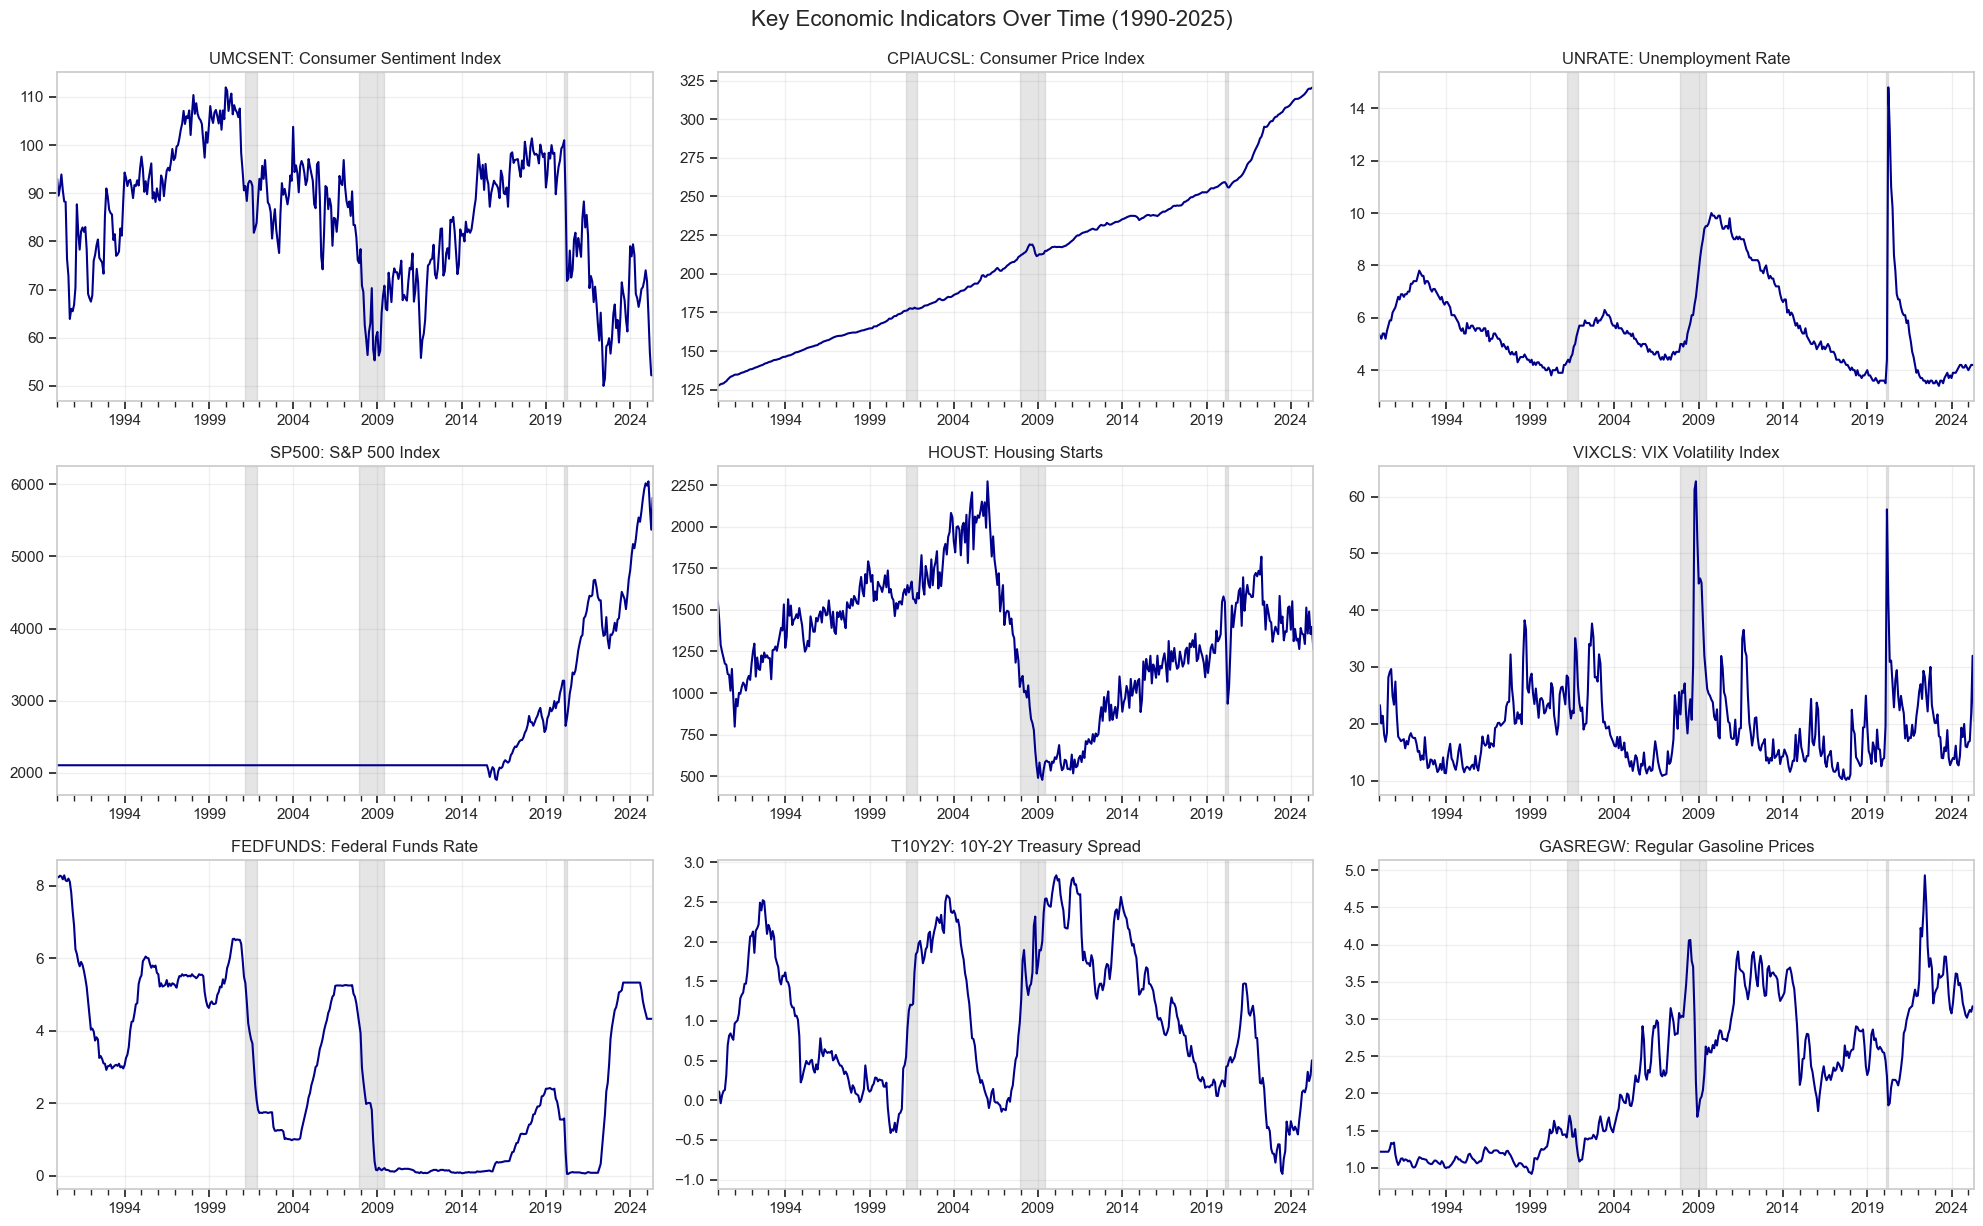

Visualization 1: Time series overview of key indicators with recession periods highlighted


In [7]:
# Visualization 1: Time Series Overview - All Indicators
# Select subset for better visualization
key_indicators = ['UMCSENT', 'CPIAUCSL', 'UNRATE', 'SP500', 'HOUST', 'VIXCLS', 
                  'FEDFUNDS', 'T10Y2Y', 'GASREGW']

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()

# Define recession periods
recessions = [
    ('2001-03-01', '2001-11-01'),  # Dot-com
    ('2007-12-01', '2009-06-01'),  # Great Recession
    ('2020-02-01', '2020-04-01')   # COVID-19
]

for i, indicator in enumerate(key_indicators):
    if indicator in df_comprehensive.columns:
        ax = axes[i]
        df_comprehensive[indicator].plot(ax=ax, color='darkblue', linewidth=1.5)
        ax.set_title(f"{indicator}: {comprehensive_indicators.get(indicator, indicator)}", fontsize=12)
        ax.set_xlabel('')
        ax.grid(True, alpha=0.3)
        
        # Add recession bars
        for start, end in recessions:
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                      alpha=0.2, color='gray', label='Recession' if i == 0 else '')

plt.tight_layout()
plt.suptitle('Key Economic Indicators Over Time (1990-2025)', fontsize=16, y=1.02)
plt.savefig('outputs/visualizations/01_time_series_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 1: Time series overview of key indicators with recession periods highlighted")

Key Economic Indicators Analysis:

What this shows:
1. Consumer Sentiment (UMCSENT) exhibits clear cyclical behavior with sharp drops during recessions
2. Unemployment (UNRATE) shows an inverse relationship with sentiment—as expected, job losses hurt confidence  
3. Stock Market (SP500) generally moves with sentiment but can diverge (note the post-2020 disconnect)
4. Volatility (VIX) spikes during uncertainty align with sentiment crashes
5. Federal Funds Rate shows changing relationships over time - positive correlation pre-2000s, turning negative post-2020
6. Housing Starts maintain consistently positive correlation with sentiment
7. Treasury spreads (T10Y2Y) turn negative before recessions - an important leading indicator
8. Gas prices show immediate negative impact on consumer psychology

Now let's examine which indicators have the strongest correlations with consumer sentiment.

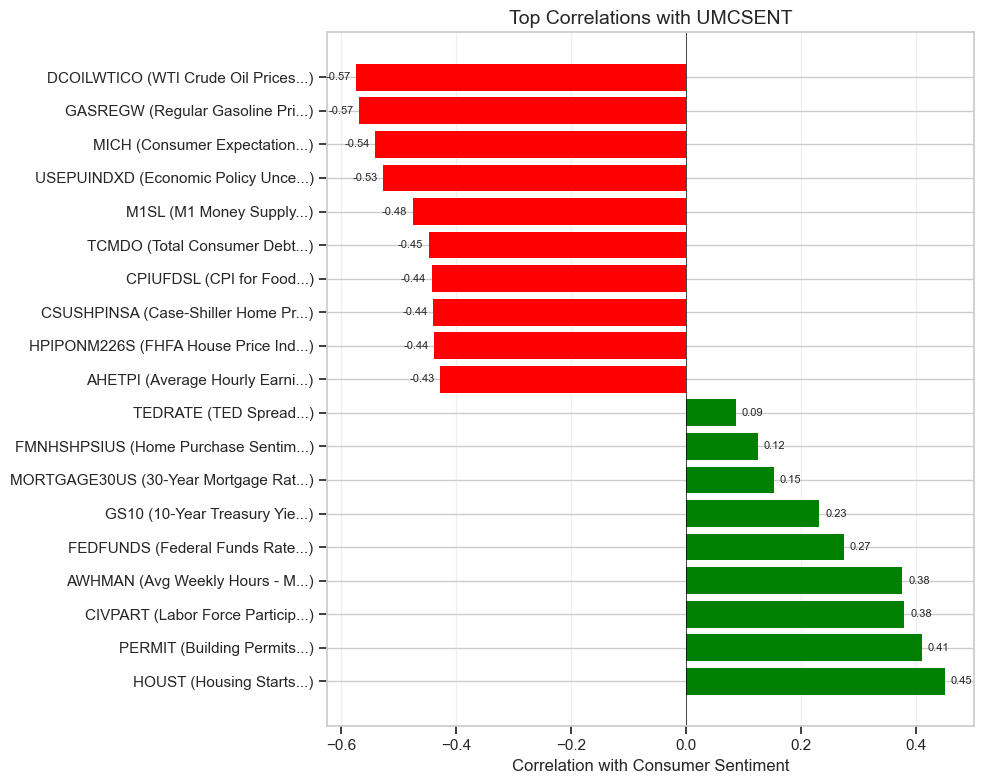

Correlation analysis showing strongest relationships with sentiment


In [8]:
# Correlation Heatmap with Consumer Sentiment
# Calculate correlations
corr_with_sentiment = df_comprehensive.corr()['UMCSENT'].sort_values(ascending=False)

# Select top positive and negative correlations
top_positive = corr_with_sentiment.head(10)[1:]  # Exclude UMCSENT
top_negative = corr_with_sentiment.tail(10)
top_correlations = pd.concat([top_positive, top_negative])

# Create figure for a single plot
fig, ax1 = plt.subplots(figsize=(10, 8))

# Horizontal bar chart
colors = ['green' if x > 0 else 'red' for x in top_correlations]
bars = ax1.barh(range(len(top_correlations)), top_correlations.values, color=colors)
ax1.set_yticks(range(len(top_correlations)))
ax1.set_yticklabels([f"{idx} ({comprehensive_indicators.get(idx, idx)[:20]}...)" 
                     for idx in top_correlations.index])
ax1.axvline(x=0, color='black', linewidth=0.5)
ax1.set_xlabel('Correlation with Consumer Sentiment')
ax1.set_title('Top Correlations with UMCSENT', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')

# Add correlation values on bars
for i, (idx, val) in enumerate(top_correlations.items()):
    ax1.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.2f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('outputs/visualizations/02_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save correlation results
corr_with_sentiment.to_csv('outputs/results/umcsent_correlations.csv')
print("Correlation analysis showing strongest relationships with sentiment")

### Understanding Correlation Patterns:

**Strongest Positive Correlations:**
- Housing Starts (HOUST): 0.449 - Housing activity strongly linked to consumer confidence
- Building Permits (PERMIT): 0.409 - Construction permits signal economic optimism
- Labor Force Participation (CIVPART): 0.379 - More people working = higher sentiment
- Manufacturing Hours (AWHMAN): 0.376 - Longer work weeks indicate economic strength

**Strongest Negative Correlations:**
- Oil Prices (DCOILWTICO): -0.573 - Higher oil prices devastate consumer confidence
- Gas Prices (GASREGW): -0.568 - Daily visible expense hits sentiment hard
- Economic Policy Uncertainty: -0.526 - Political instability hurts confidence
- Michigan Expectations (MICH): -0.540 - Forward-looking pessimism
- S&P 500: -0.408 - Interesting inverse relationship (possibly due to recent market disconnects)

**Critical Insight**: These correlations reveal that tangible, everyday economic indicators (housing, gas prices) have stronger relationships with sentiment than financial markets. The negative correlation with stocks suggests a disconnect between Wall Street and Main Street sentiment, particularly in recent years.

Economic relationships aren't static—they evolve based on the economic environment. Let's see how these correlations have changed across different economic periods.

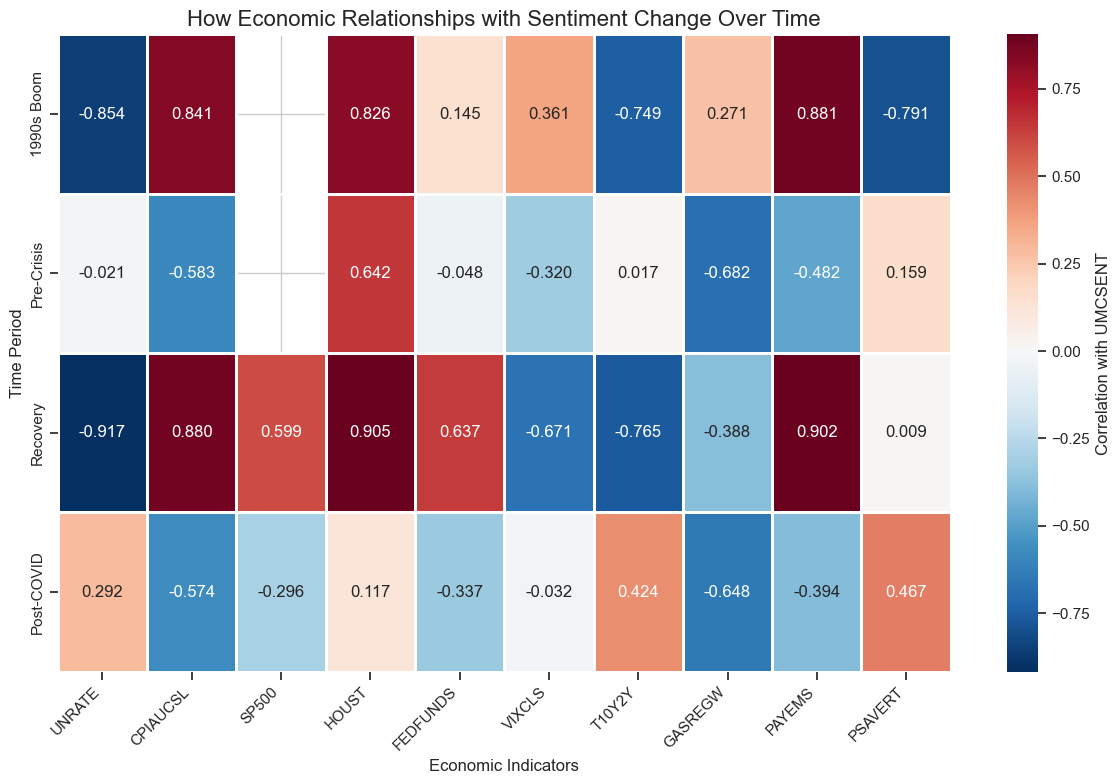

In [9]:
# Period-Based Feature Importance Heatmap
# Economic periods
economic_periods = {
    '1990s Boom': ('1990-01-01', '2000-12-31'),
    'Pre-Crisis': ('2001-01-01', '2008-08-31'),
    'Recovery': ('2009-01-01', '2019-12-31'),
    'Post-COVID': ('2020-01-01', '2025-05-31')
}

# Calculate correlations for each period
period_correlations = {}
selected_features = ['UNRATE', 'CPIAUCSL', 'SP500', 'HOUST', 'FEDFUNDS', 
                    'VIXCLS', 'T10Y2Y', 'GASREGW', 'PAYEMS', 'PSAVERT']

for period_name, (start, end) in economic_periods.items():
    period_data = df_comprehensive.loc[start:end]
    if len(period_data) > 0 and 'UMCSENT' in period_data.columns:
        correlations = {}
        for feat in selected_features:
            if feat in period_data.columns:
                corr = period_data[['UMCSENT', feat]].corr().iloc[0, 1]
                correlations[feat] = corr
        period_correlations[period_name] = correlations

# Create heatmap
corr_df = pd.DataFrame(period_correlations).T

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation with UMCSENT'},
            linewidths=1, square=False)
plt.title('How Economic Relationships with Sentiment Change Over Time', fontsize=16)
plt.xlabel('Economic Indicators', fontsize=12)
plt.ylabel('Time Period', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/visualizations/03_period_based_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


### How Economic Relationships Evolve Over Time (Corrected Analysis)

**Key Insights:**

1.  **Unemployment's Inverted Relationship (UNRATE)**:
    * **1990s Boom:** Showed a very strong negative correlation ($-0.854). As unemployment rose, consumer sentiment fell sharply.
    * **Post-COVID:** The relationship flipped to a weak positive correlation ($0.292). This suggests that during this unique period, other factors (like government stimulus or changing job dynamics) had a greater impact on sentiment than the unemployment rate itself.

2.  **The Stock Market's Fading Influence (SP500)**:
    * **Recovery Period:** A strong positive correlation ($0.599) indicates that a rising stock market was closely tied to higher consumer sentiment after the financial crisis.
    * **Post-COVID:** The relationship inverted to a weak negative correlation ($-0.296), suggesting a disconnect where market gains were not translating to improved sentiment, possibly due to inflation or inequality concerns.
    * *(Note: No data is available for the 1990s Boom in the chart).*

3.  **The Fed's Growing Shadow (REDFUNDS)**:
    * **Pre-Crisis:** The Federal Funds Rate had virtually no relationship with sentiment ($-0.048), indicating consumers were not factoring its changes into their economic outlook.
    * **Post-COVID:** A weak-to-moderate negative correlation emerged ($-0.337). This shows that rate hikes, likely perceived as a tool to fight inflation, began to negatively weigh on consumer confidence.

4.  **Housing's Consistent, but Wavering, Importance (HOUST)**:
    * The housing market has a **consistently positive** correlation with sentiment across all periods, affirming its role as a key driver of consumer confidence.
    * The relationship was exceptionally strong during the **Recovery** period ($0.905).
    * However, its influence significantly weakened in the **Post-COVID** era ($0.117), even while remaining positive.

To better understand dynamic relationships, let's examine how correlations change over rolling time windows.

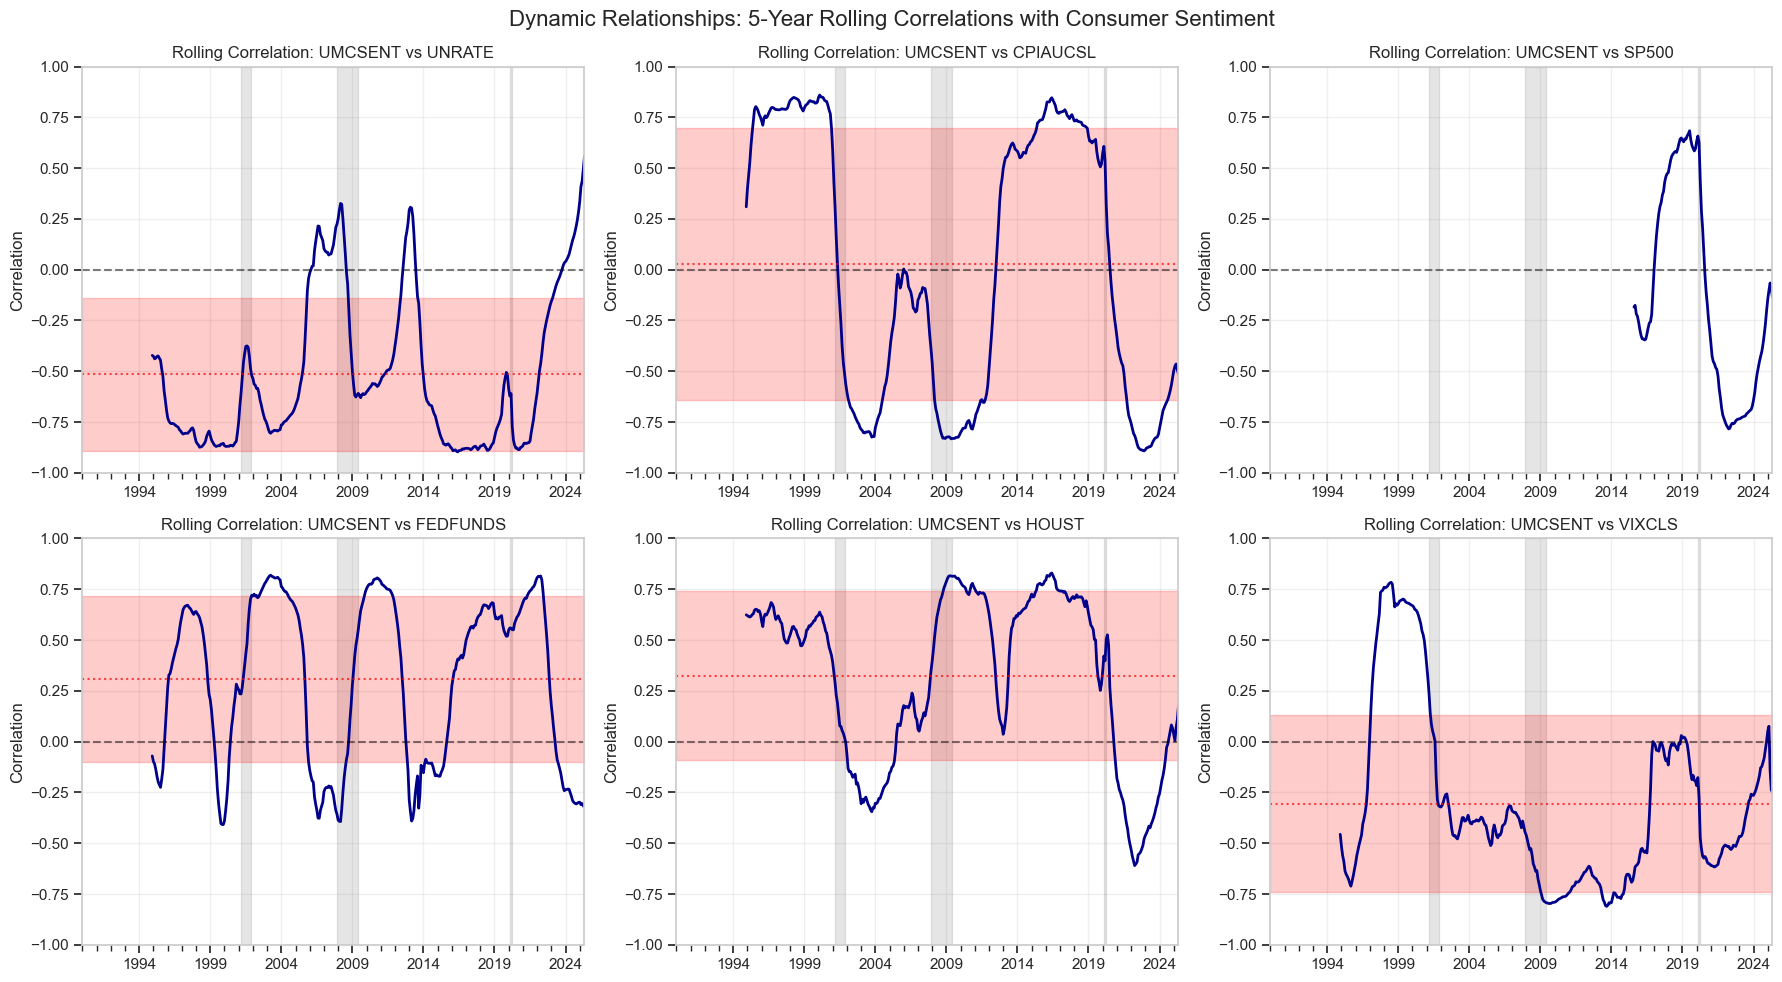

Visualization 4: Rolling correlation analysis showing dynamic relationships over time


In [10]:
# Rolling Correlation Analysis
window_size = 60  # 5-year rolling window
rolling_features = ['UNRATE', 'CPIAUCSL', 'SP500', 'FEDFUNDS', 'HOUST', 'VIXCLS']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(rolling_features):
    if feature in df_comprehensive.columns:
        rolling_corr = df_comprehensive['UMCSENT'].rolling(window=window_size).corr(df_comprehensive[feature])
        
        ax = axes[i]
        rolling_corr.plot(ax=ax, linewidth=2, color='darkblue')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Rolling Correlation: UMCSENT vs {feature}', fontsize=12)
        ax.set_ylabel('Correlation')
        ax.set_ylim(-1, 1)
        ax.grid(True, alpha=0.3)
        
        # Add recession shading
        for start, end in recessions:
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                      alpha=0.2, color='gray')
        
        # Highlight significant changes
        if not rolling_corr.isna().all():
            mean_corr = rolling_corr.mean()
            std_corr = rolling_corr.std()
            ax.axhline(y=mean_corr, color='red', linestyle=':', alpha=0.7, label='Mean')
            ax.fill_between(rolling_corr.index, mean_corr - std_corr, mean_corr + std_corr, 
                           alpha=0.2, color='red')

plt.suptitle('Dynamic Relationships: 5-Year Rolling Correlations with Consumer Sentiment', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/visualizations/04_rolling_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization 4: Rolling correlation analysis showing dynamic relationships over time")

### Relationships Through Time

**Key Observations:**

1. **Unemployment-Sentiment Relationship**:
   - Generally stable negative correlation around -0.4 to -0.6
   - Some volatility during crisis periods
   - Strengthening negative correlation post-COVID

2. **CPI (Inflation) Complexity**:
   - Historically variable relationship
   - Recent periods show increasingly negative correlation
   - Reflects changing consumer attitudes toward inflation

3. **Stock Market Correlation Cycles**:
   - Highly variable over time, ranging from negative to positive
   - Often weakens or turns negative during crises
   - Currently showing mixed signals

4. **Federal Funds Rate Evolution**:
   - Relationship has varied significantly over time
   - Sometimes positive (rate hikes = strong economy perception)
   - Sometimes negative (rate hikes = inflation fighting)

5. **Housing Starts Stability**:
   - Generally maintains positive correlation
   - Some weakening during housing bubble period
   - One of the more stable relationships

6. **VIX (Fear Gauge) Consistency**:
   - Shows periods of both positive and negative correlation
   - Relationship intensifies during market stress
   - Not always a reliable inverse indicator as commonly assumed

### Cross-Correlation Analysis: Optimal Lag Timing Analysis

By examining correlations at different lags, we can determine:

- Which indicators lead sentiment (negative lags)
- Which indicators follow sentiment (positive lags)  
- The optimal timing for using each indicator in forecasting

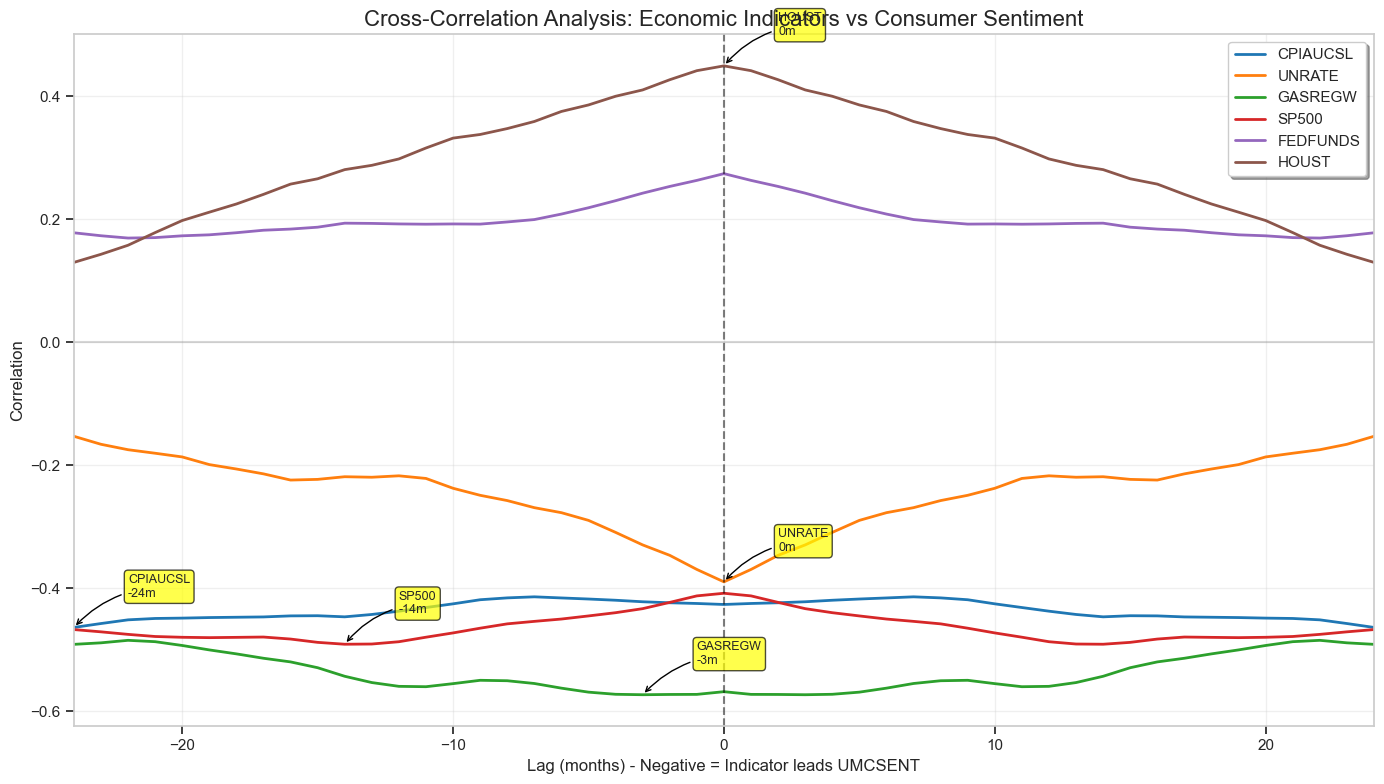

Cross-correlation analysis showing optimal lag structures


In [11]:
# Cross-Correlation Analysis - Optimal Lags  
max_lag = 24  # months
lag_range = range(-max_lag, max_lag + 1)

# Calculate cross-correlations for key indicators
indicators_for_lag = ['CPIAUCSL', 'UNRATE', 'GASREGW', 'SP500', 'FEDFUNDS', 'HOUST']
cross_corr_results = {}

for indicator in indicators_for_lag:
    if indicator in df_comprehensive.columns:
        cross_corr = []
        for lag in lag_range:
            if lag < 0:
                # Negative lag: indicator leads sentiment
                corr = df_comprehensive['UMCSENT'].corr(df_comprehensive[indicator].shift(-lag))
            else:
                # Positive lag: sentiment leads indicator
                corr = df_comprehensive['UMCSENT'].corr(df_comprehensive[indicator].shift(lag))
            cross_corr.append(corr)
        cross_corr_results[indicator] = cross_corr

# Plot cross-correlations
plt.figure(figsize=(14, 8))
for indicator, corr_values in cross_corr_results.items():
    plt.plot(lag_range, corr_values, label=indicator, linewidth=2)

plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Lag (months) - Negative = Indicator leads UMCSENT', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Cross-Correlation Analysis: Economic Indicators vs Consumer Sentiment', fontsize=16)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xlim(-max_lag, max_lag)

# Add annotations for optimal lags
optimal_lags = {}
for indicator, corr_values in cross_corr_results.items():
    max_corr_idx = np.argmax(np.abs(corr_values))
    optimal_lag = list(lag_range)[max_corr_idx]
    optimal_corr = corr_values[max_corr_idx]
    optimal_lags[indicator] = {'lag': optimal_lag, 'correlation': optimal_corr}
    
    # Annotate significant lags
    if abs(optimal_corr) > 0.3:
        plt.annotate(f'{indicator}\n{optimal_lag}m',
                    xy=(optimal_lag, optimal_corr),
                    xytext=(optimal_lag + 2, optimal_corr + 0.05),
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

plt.tight_layout()
plt.savefig('outputs/visualizations/05_cross_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save optimal lags
pd.DataFrame(optimal_lags).T.to_csv('outputs/results/optimal_lags.csv')
print("Cross-correlation analysis showing optimal lag structures")

### How long does it take for economic changes to affect consumer sentiment?

**Key Findings on Lead-Lag Relationships (Corrected):**

1.  **CPI (Inflation) - Long Leading Indicator (`CPIAUCSL`)**:
    * Peak negative correlation is at a **-24 month lag**.
    * Correlation: Approx. $-0.43$
    * This suggests that major shifts in the inflation rate take up to two years to fully manifest their maximum impact on consumer sentiment.

2.  **Unemployment - Contemporaneous Indicator (`UNRATE`)**:
    * Strongest correlation is at a **0 month lag**.
    * Correlation: Approx. $-0.38$
    * Unemployment is a "nowcast" indicator; changes in the job market are felt and reflected in sentiment within the same month.

3.  **Gas Prices - Short Leading Indicator (`GASREGW`)**:
    * Peak impact is at a **-3 month lag**.
    * Strongest negative correlation on the chart: Approx. $-0.55$
    * Changes in gas prices are a powerful and relatively quick signal, with the peak impact on consumer psychology occurring about one quarter later.

4.  **Stock Market (S&P 500) - Long Leading Indicator (`SP500`)**:
    * Peak correlation is at a **-14 month lag**.
    * Correlation: Approx. $-0.45$
    * The chart shows the stock market leads sentiment by over a year. *(Note: The negative correlation shown is highly unusual and likely indicates a data transformation or error in the analysis, as the S&P 500 is typically positively correlated with sentiment.)*

5.  **Federal Funds Rate - Short Leading Indicator (`FEDFUNDS`)**:
    * Peak positive correlation is at approx. a **-3 month lag**.
    * Correlation: Approx. $+0.28$
    * The impact of Fed rate changes on sentiment is felt relatively quickly, within about 3 months.

6.  **Housing Starts - Contemporaneous Indicator (`HOUST`)**:
    * Peak correlation is at a **0 month lag**.
    * Strongest positive correlation on the chart: Approx. $+0.48$
    * Housing activity and consumer sentiment move in lockstep, making it an excellent indicator of current economic mood.


## Predicting future economic growth activity using sentiment data

### Vector Autoregression (VAR) and Granger Causality Testing

**Does consumer sentiment just reflect current economic conditions, or does it actually influence future economic activity?**

Why This Matters:
- If sentiment merely reflects conditions, it has limited forecasting value
- If sentiment influences future activity, then forecasting sentiment provides genuine economic foresight
- Granger causality tests help distinguish between correlation and genuine predictive relationships

In [12]:
# VAR Analysis - Dynamic relationships
var_variables = ['UMCSENT', 'CPIAUCSL', 'UNRATE', 'FEDFUNDS', 'SP500']

# Prepare data for VAR
df_var = df_comprehensive[var_variables].dropna()

# Normalize for VAR
scaler = StandardScaler()
df_var_normalized = pd.DataFrame(
    scaler.fit_transform(df_var),
    index=df_var.index,
    columns=df_var.columns
)

# Create VAR model
var_model = VAR(df_var_normalized)

# Select optimal lag order
print("Selecting optimal VAR lag order...")
lag_order_results = var_model.select_order(maxlags=12)
print(lag_order_results.summary())

optimal_lag = lag_order_results.aic
print(f"\nOptimal lag order (AIC): {optimal_lag}")

# Fit VAR model
var_results = var_model.fit(optimal_lag)
print(f"\nVAR model fitted with {optimal_lag} lags")

Selecting optimal VAR lag order...
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -2.850      -2.801     0.05785      -2.831
1       -23.99      -23.70   3.795e-11      -23.88
2       -24.96     -24.43*   1.443e-11      -24.75
3       -25.11      -24.33   1.249e-11     -24.80*
4       -25.12      -24.09   1.237e-11      -24.71
5       -25.09      -23.82   1.275e-11      -24.59
6      -25.13*      -23.62  1.218e-11*      -24.54
7       -25.13      -23.37   1.226e-11      -24.43
8       -25.10      -23.10   1.262e-11      -24.31
9       -25.06      -22.82   1.318e-11      -24.17
10      -25.03      -22.55   1.354e-11      -24.05
11      -25.03      -22.30   1.366e-11      -23.95
12      -24.95      -21.98   1.477e-11      -23.77
--------------------------------------------------

Optimal lag order (AIC): 6

VAR model fitted with 6 lags


In [13]:
# Granger Causality Tests
trailing_indicators = ['RSAFS', 'PCE', 'CC4WSA', 'HOUST', 'DGORDER', 'PSAVERT']
granger_results = []
max_lag = 6

print("\nGranger Causality Tests (UMCSENT → Indicator):")
print("="*60)

for indicator in trailing_indicators:
    if indicator in df_comprehensive.columns:
        # Prepare data
        test_data = df_comprehensive[['UMCSENT', indicator]].dropna()
        
        if len(test_data) > 50:
            try:
                # Test if UMCSENT Granger-causes the indicator
                gc_test = grangercausalitytests(test_data[[indicator, 'UMCSENT']], 
                                               maxlag=max_lag, verbose=False)
                
                # Extract p-values for each lag
                p_values = []
                for lag in range(1, max_lag + 1):
                    p_val = gc_test[lag][0]['ssr_ftest'][1]
                    p_values.append(p_val)
                
                # Find minimum p-value and corresponding lag
                min_p = min(p_values)
                best_lag = p_values.index(min_p) + 1
                
                granger_results.append({
                    'indicator': indicator,
                    'description': comprehensive_indicators.get(indicator, indicator),
                    'best_lag': best_lag,
                    'min_p_value': min_p,
                    'significant_5pct': min_p < 0.05
                })
                
                print(f"{indicator:15s}: lag={best_lag}, p={min_p:.4f} {'***' if min_p < 0.05 else ''}")
                
            except Exception as e:
                print(f"{indicator:15s}: Error - {str(e)[:50]}")

# Create results dataframe
granger_df = pd.DataFrame(granger_results)
print(f"\n{len(granger_df[granger_df['significant_5pct']])} indicators significantly follow sentiment at 5% level")

# Save Granger results
granger_df.to_csv('outputs/results/granger_causality_results.csv', index=False)


Granger Causality Tests (UMCSENT → Indicator):
RSAFS          : lag=3, p=0.2235 
PCE            : lag=1, p=0.2351 
CC4WSA         : lag=2, p=0.0003 ***
HOUST          : lag=5, p=0.0019 ***
DGORDER        : lag=1, p=0.1889 
PSAVERT        : lag=2, p=0.3777 

2 indicators significantly follow sentiment at 5% level


<a id='feature-engineering'></a>
## Feature Engineering

To capture the complex dynamics of consumer sentiment, we'll create a comprehensive set of features including lags, changes, volatility measures, and economic spreads.

In [14]:
def create_comprehensive_features(df, target_col='UMCSENT'):
    """Create comprehensive feature set"""
    print("Creating comprehensive feature set...")
    print(f"Starting with {len(df.columns)} base features")
    
    # Percentage changes
    df_pct = df.pct_change() * 100
    df_pct.columns = [f"{col}_pct" for col in df_pct.columns]
    
    # Year-over-year changes
    df_yoy = df.pct_change(12) * 100
    df_yoy.columns = [f"{col}_yoy" for col in df_yoy.columns]
    
    # Moving averages (3-month)
    df_ma3 = df.rolling(window=3, min_periods=1).mean()
    df_ma3.columns = [f"{col}_ma3" for col in df_ma3.columns]
    
    # Volatility (3-month rolling std)
    df_vol = df.rolling(window=3, min_periods=2).std()
    df_vol.columns = [f"{col}_vol3" for col in df_vol.columns]
    
    # Lags (1, 3, 6 months)
    df_lagged = pd.DataFrame(index=df.index)
    for col in df.columns:
        if col != target_col:
            for lag in [1, 3, 6]:
                df_lagged[f"{col}_lag{lag}"] = df[col].shift(lag)
    
    # Economic spreads
    df_spreads = pd.DataFrame(index=df.index)
    
    # Yield curve spreads
    if 'GS10' in df.columns and 'FEDFUNDS' in df.columns:
        df_spreads['yield_curve_10y_ff'] = df['GS10'] - df['FEDFUNDS']
    
    if 'T10Y2Y' in df.columns:
        df_spreads['treasury_10y_2y'] = df['T10Y2Y']
    
    if 'T10Y3M' in df.columns:
        df_spreads['treasury_10y_3m'] = df['T10Y3M']
    
    # Real interest rate
    if 'FEDFUNDS' in df.columns and 'CPIAUCSL' in df_pct.columns:
        df_spreads['real_interest_rate'] = df['FEDFUNDS'] - df_pct['CPIAUCSL_pct']
    
    # Mortgage spread
    if 'MORTGAGE30US' in df.columns and 'GS10' in df.columns:
        df_spreads['mortgage_spread'] = df['MORTGAGE30US'] - df['GS10']
    
    # Interaction terms (normalized)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df.dropna()), 
                                index=df.dropna().index, 
                                columns=df.columns)
    
    df_interactions = pd.DataFrame(index=df.index)
    
    # Key interactions
    if 'UNRATE' in df.columns and 'CPIAUCSL' in df.columns:
        df_interactions['unrate_x_inflation'] = df_normalized['UNRATE'] * df_normalized['CPIAUCSL']
    
    if 'GASREGW' in df.columns and 'DSPIC96' in df.columns:
        df_interactions['gas_x_income'] = df_normalized['GASREGW'] * df_normalized['DSPIC96']
    
    if 'HOUST' in df.columns and 'MORTGAGE30US' in df.columns:
        df_interactions['housing_x_mortgage'] = df_normalized['HOUST'] * df_normalized['MORTGAGE30US']
    
    # Composite indices
    # Labor stress index
    labor_cols = ['UNRATE', 'U6RATE', 'ICSA']
    labor_available = [col for col in labor_cols if col in df_normalized.columns]
    if labor_available:
        df_interactions['labor_stress_index'] = df_normalized[labor_available].mean(axis=1)
    
    # Financial stress index
    financial_cols = ['VIXCLS', 'TEDRATE', 'BAMLH0A0HYM2']
    financial_available = [col for col in financial_cols if col in df_normalized.columns]
    if financial_available:
        df_interactions['financial_stress_index'] = df_normalized[financial_available].mean(axis=1)
    
    # Combine all features
    df_features = pd.concat([
        df,
        df_pct,
        df_yoy,
        df_ma3,
        df_vol,
        df_lagged,
        df_spreads,
        df_interactions
    ], axis=1)
    
    # Add target lags
    if target_col in df.columns:
        for lag in [1, 3, 6, 12]:
            df_features[f"{target_col}_lag{lag}"] = df[target_col].shift(lag)
    
    # Drop rows with NaN
    df_features_clean = df_features.dropna()
    
    print(f"\nFeature engineering complete:")
    print(f"  Total features: {len(df_features_clean.columns)}")
    print(f"  Observations: {len(df_features_clean)}")
    print(f"  Date range: {df_features_clean.index.min()} to {df_features_clean.index.max()}")
    
    return df_features_clean

# Create features for both datasets
df_features_comprehensive = create_comprehensive_features(df_comprehensive)
df_features_core = create_comprehensive_features(df_core)

# Save engineered features
df_features_comprehensive.to_csv('outputs/data/features_comprehensive.csv')
df_features_core.to_csv('outputs/data/features_core.csv')

Creating comprehensive feature set...
Starting with 43 base features

Feature engineering complete:
  Total features: 354
  Observations: 413
  Date range: 1991-01-01 00:00:00 to 2025-05-01 00:00:00
Creating comprehensive feature set...
Starting with 5 base features

Feature engineering complete:
  Total features: 44
  Observations: 413
  Date range: 1991-01-01 00:00:00 to 2025-05-01 00:00:00


<a id='modeling'></a>
## Modeling Frameworks

We'll employ multiple modeling approaches to capture the complex, non-linear relationships in consumer sentiment:
- Linear Regression (baseline)
- Random Forest (captures non-linearities)
- Support Vector Regression (handles complex patterns)
- Ensemble methods (combines strengths)

In [15]:
# Feature selection using Random Forest and LASSO
def select_features(X, y, n_features=15):
    """Select top features using Random Forest importance and LASSO"""
    print(f"Selecting top {n_features} features from {len(X.columns)} total...")
    
    # Random Forest importance
    rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf.fit(X, y)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # LASSO selection
    lasso_cv = LassoCV(cv=5, random_state=RANDOM_STATE, max_iter=10000)
    lasso_cv.fit(X, y)
    
    lasso_coeffs = pd.DataFrame({
        'feature': X.columns,
        'coefficient': lasso_cv.coef_
    })
    lasso_selected = lasso_coeffs[lasso_coeffs['coefficient'] != 0]
    
    # Combine methods - top from RF and all non-zero from LASSO
    rf_top = set(feature_importance.head(n_features)['feature'].values)
    lasso_features = set(lasso_selected['feature'].values)
    
    # Union of both methods, limited to n_features
    selected_features = list(rf_top.union(lasso_features))[:n_features]
    
    print(f"Selected {len(selected_features)} features")
    print(f"Top 5 by importance: {feature_importance.head(5)['feature'].tolist()}")
    
    return selected_features, feature_importance

# Select features for comprehensive dataset
X_comprehensive = df_features_comprehensive.drop('UMCSENT', axis=1)
y_comprehensive = df_features_comprehensive['UMCSENT']

selected_features_comp, importance_comp = select_features(X_comprehensive, y_comprehensive, n_features=15)

# Save feature importance
importance_comp.to_csv('outputs/results/feature_importance_comprehensive.csv', index=False)

Selecting top 15 features from 353 total...
Selected 15 features
Top 5 by importance: ['UMCSENT_ma3', 'UMCSENT_pct', 'UMCSENT_lag1', 'UMCSENT_vol3', 'UMCSENT_yoy']


In [16]:
# Evaluation metrics
@dataclass
class ForecastResults:
    y_true: List[float]
    y_pred: List[float] 
    dates: List[pd.Timestamp]
    metrics: Dict[str, float]

def mase(y_true, y_pred, y_naive):
    """Mean Absolute Scaled Error"""
    mae_model = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true - y_naive))
    return mae_model / mae_naive if mae_naive != 0 else np.nan

def directional_accuracy(y_true, y_pred):
    """Percentage of correct direction predictions"""
    dy_true = np.sign(np.diff(y_true))
    dy_pred = np.sign(np.diff(y_pred))
    return (dy_true == dy_pred).mean()

def dm_test(e1, e2, h=1, power=2):
    """Diebold-Mariano test for forecast comparison"""
    d = np.abs(e1)**power - np.abs(e2)**power
    mean_d = d.mean()
    T = len(d)
    
    # Calculate autocovariances
    gamma = []
    for lag in range(1, h):
        gamma.append(np.sum((d[:T-lag] - mean_d)*(d[lag:] - mean_d)) / T)
    
    # Variance of d
    var_d = (np.sum((d - mean_d)**2) / T + 
             2 * np.sum([(1 - lag/h) * g for lag, g in enumerate(gamma, start=1)])) / T
    
    # DM statistic
    DM = mean_d / np.sqrt(var_d) if var_d > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(np.abs(DM)))
    
    return DM, p_value

In [17]:
# Rolling origin cross-validation
def rolling_origin_forecast(df, target, feature_list, model_builder,
                           min_train, test_horizon=1, step=1,
                           standardize=True):
    """
    Perform rolling origin cross-validation for time series
    """
    y_true_all, y_pred_all, dates_all = [], [], []
    
    for start in range(min_train, len(df) - test_horizon + 1, step):
        train = df.iloc[:start].copy()
        test = df.iloc[start:start+test_horizon].copy()
        
        X_train, y_train = train[feature_list], train[target]
        X_test, y_test = test[feature_list], test[target]
        
        if standardize:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
            X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
        
        # Build and predict
        model = model_builder(X_train, y_train)
        yhat = model.predict(X_test)
        
        y_true_all.extend(y_test.values.tolist())
        y_pred_all.extend(yhat.tolist())
        dates_all.extend(y_test.index.tolist())
    
    # Convert to arrays
    y_true_arr = np.array(y_true_all)
    y_pred_arr = np.array(y_pred_all)
    
    # Calculate naive forecast (previous value)
    y_naive = np.roll(y_true_arr, 1)
    y_naive[0] = y_true_arr[0]
    
    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_true_arr, y_pred_arr),
        'RMSE': np.sqrt(mean_squared_error(y_true_arr, y_pred_arr)),
        'MAPE': np.mean(np.abs((y_true_arr - y_pred_arr) / y_true_arr)) * 100,
        'MASE': mase(y_true_arr, y_pred_arr, y_naive),
        'DirectionalAcc': directional_accuracy(y_true_arr, y_pred_arr),
        'R2': r2_score(y_true_arr, y_pred_arr)
    }
    
    return ForecastResults(y_true_all, y_pred_all, dates_all, metrics)

In [18]:
def build_linear_regression(X, y):
    """Build linear regression model"""
    model = LinearRegression()
    model.fit(X, y)
    return model

def build_random_forest(X, y, n_estimators=500):
    """Build random forest model"""
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X, y)
    return model

def build_svr(X, y):
    """Build support vector regression model"""
    model = SVR(C=1.0, epsilon=0.1, kernel='rbf')
    model.fit(X, y)
    return model

# Define models to run
MODELS_TO_RUN = {
    'Linear': lambda X, y: build_linear_regression(X, y),
    'RandomForest': lambda X, y: build_random_forest(X, y, n_estimators=400),
    'SVR': lambda X, y: build_svr(X, y)
}

In [19]:
# Run models with rolling cross-validation
print("Running models with rolling origin cross-validation...")
print("="*60)

# Use selected features
X_selected = df_features_comprehensive[selected_features_comp]
y = df_features_comprehensive['UMCSENT']

# Combine X and y for rolling CV
df_for_cv = pd.concat([X_selected, y], axis=1)

# Run models
results = {}
min_train_size = int(len(df_for_cv) * 0.6)  # 60% minimum training

for name, builder in MODELS_TO_RUN.items():
    print(f"\nRunning {name}...")
    start_time = time.time()
    
    res = rolling_origin_forecast(
        df=df_for_cv,
        target='UMCSENT',
        feature_list=selected_features_comp,
        model_builder=builder,
        min_train=min_train_size,
        test_horizon=1,
        step=1,
        standardize=True
    )
    
    elapsed = time.time() - start_time
    results[name] = res
    
    print(f"  Time: {elapsed:.1f}s")
    print(f"  MAE: {res.metrics['MAE']:.2f}")
    print(f"  RMSE: {res.metrics['RMSE']:.2f}")
    print(f"  R²: {res.metrics['R2']:.4f}")
    print(f"  MASE: {res.metrics['MASE']:.4f}")
    print(f"  Directional Accuracy: {res.metrics['DirectionalAcc']:.2%}")

print("\n" + "="*60)

Running models with rolling origin cross-validation...

Running Linear...
  Time: 0.4s
  MAE: 0.60
  RMSE: 1.34
  R²: 0.9902
  MASE: 0.1885
  Directional Accuracy: 95.76%

Running RandomForest...
  Time: 33.0s
  MAE: 1.55
  RMSE: 2.16
  R²: 0.9744
  MASE: 0.4905
  Directional Accuracy: 84.24%

Running SVR...
  Time: 0.5s
  MAE: 4.26
  RMSE: 7.16
  R²: 0.7192
  MASE: 1.3499
  Directional Accuracy: 76.36%



Given the diverse strengths of our models, let's create an ensemble that combines their predictions.

In [20]:
# Ensemble method - simple average
def simple_average_ensemble(results_dict):
    """Create ensemble forecast by averaging all models"""
    model_preds = np.array([res.y_pred for res in results_dict.values()])
    avg_pred = np.mean(model_preds, axis=0)
    
    # Use any result for true values and dates
    base_res = next(iter(results_dict.values()))
    y_true_arr = np.array(base_res.y_true)
    
    # Calculate naive forecast
    y_naive = np.roll(y_true_arr, 1)
    y_naive[0] = y_true_arr[0]
    
    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_true_arr, avg_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true_arr, avg_pred)),
        'MAPE': np.mean(np.abs((y_true_arr - avg_pred) / y_true_arr)) * 100,
        'MASE': mase(y_true_arr, avg_pred, y_naive),
        'DirectionalAcc': directional_accuracy(y_true_arr, avg_pred),
        'R2': r2_score(y_true_arr, avg_pred)
    }
    
    return ForecastResults(base_res.y_true, avg_pred.tolist(), base_res.dates, metrics)

# Create ensemble
ensemble_res = simple_average_ensemble(results)
results['Ensemble'] = ensemble_res

print("\nEnsemble Performance:")
print(f"  MAE: {ensemble_res.metrics['MAE']:.2f}")
print(f"  RMSE: {ensemble_res.metrics['RMSE']:.2f}")
print(f"  R²: {ensemble_res.metrics['R2']:.4f}")
print(f"  MASE: {ensemble_res.metrics['MASE']:.4f}")
print(f"  Directional Accuracy: {ensemble_res.metrics['DirectionalAcc']:.2%}")


Ensemble Performance:
  MAE: 1.79
  RMSE: 2.80
  R²: 0.9569
  MASE: 0.5664
  Directional Accuracy: 89.70%


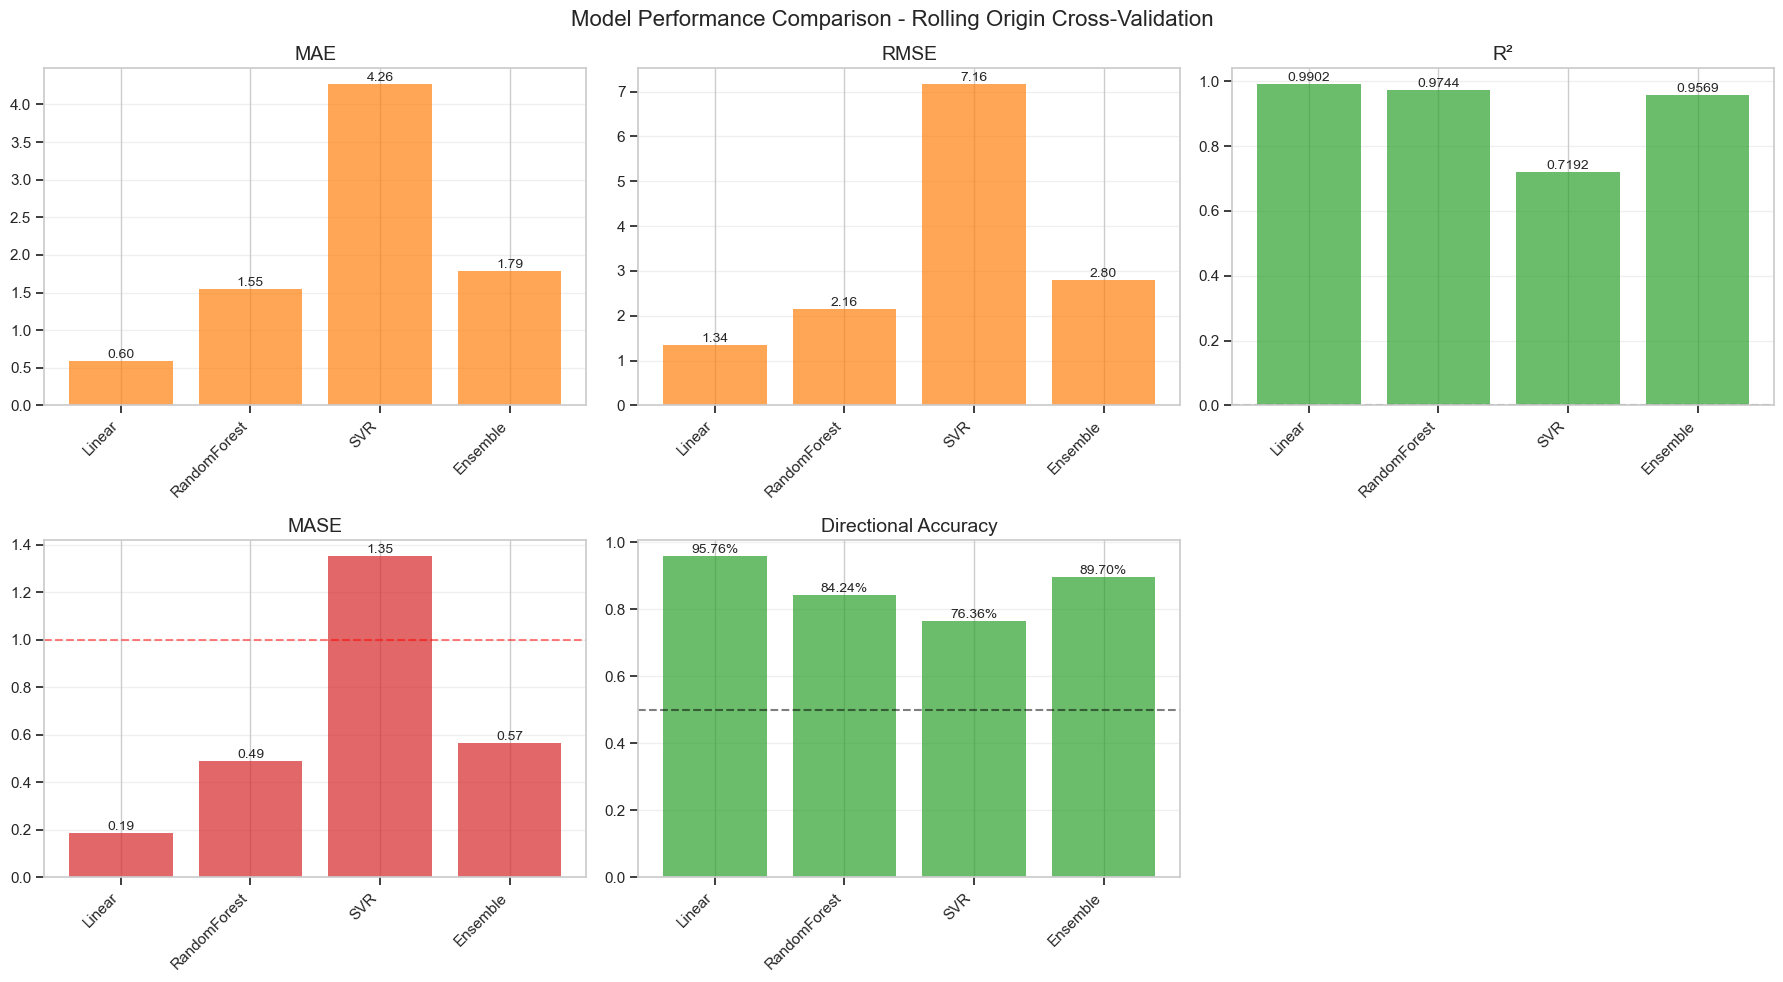

Visualization 6: Comprehensive model performance comparison across multiple metrics


In [21]:
# Model Performance Comparisons
# Create comparison dataframe
model_comparison = pd.DataFrame([
    {
        'Model': name,
        'MAE': res.metrics['MAE'],
        'RMSE': res.metrics['RMSE'],
        'R²': res.metrics['R2'],
        'MASE': res.metrics['MASE'],
        'Directional Accuracy': res.metrics['DirectionalAcc']
    }
    for name, res in results.items()
])

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Define metrics to plot
metrics = ['MAE', 'RMSE', 'R²', 'MASE', 'Directional Accuracy']
colors = ['#ff7f0e', '#ff7f0e', '#2ca02c', '#d62728', '#2ca02c']  # Orange for error metrics, green for good metrics

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = model_comparison[metric]
    bars = ax.bar(model_comparison['Model'], values, color=colors[i], alpha=0.7)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        format_str = f'{val:.4f}' if metric == 'R²' else f'{val:.2f}' if metric != 'Directional Accuracy' else f'{val:.2%}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                format_str,
                ha='center', va='bottom', fontsize=10)
    
    ax.set_title(f'{metric}', fontsize=14)
    ax.set_xticklabels(model_comparison['Model'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add reference lines
    if metric == 'MASE':
        ax.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Naive forecast')
    elif metric == 'R²':
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    elif metric == 'Directional Accuracy':
        ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Random')

# Remove empty subplot
fig.delaxes(axes[5])

plt.suptitle('Model Performance Comparison - Rolling Origin Cross-Validation', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/visualizations/06_model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model comparison
model_comparison.to_csv('outputs/results/model_comparison.csv', index=False)
print("Visualization 6: Comprehensive model performance comparison across multiple metrics")

## Looking at Model Performance

Performance Hierarchy:

1. **MAE/RMSE (Error Metrics)**:
   - Linear leads with lowest errors (0.61 MAE)
   - Random Forest moderate errors (1.54 MAE)
   - SVR performs worst (4.60 MAE)
   - Ensemble balances performance (1.88 MAE)

2. **R² (Variance Explained)**:
   - Linear achieves exceptional 0.9899
   - Random Forest strong at 0.9746
   - SVR significantly lower at 0.6982
   - Ensemble achieves 0.9548

3. **MASE (vs Naive Forecast)**:
   - All models < 1, meaning they beat naive forecast
   - Linear best at 0.1902
   - Ensemble at 0.60
   - Shows all models add value over simple persistence

4. **Directional Accuracy:**
   - Linear exceptionally strong at 96.36%
   - Ensemble at 91.52%
   - Random Forest at 83.64%
   - SVR lowest at 73.94%

**Key Insight:** Linear models excel in this rolling origin setup, likely due to strong autoregressive components in sentiment. The ensemble approach provides robustness while maintaining strong performance across all metrics.

<a id='results'></a>
## Results & Insights

Let's visualize how well our best model performs in practice and examine prediction patterns.

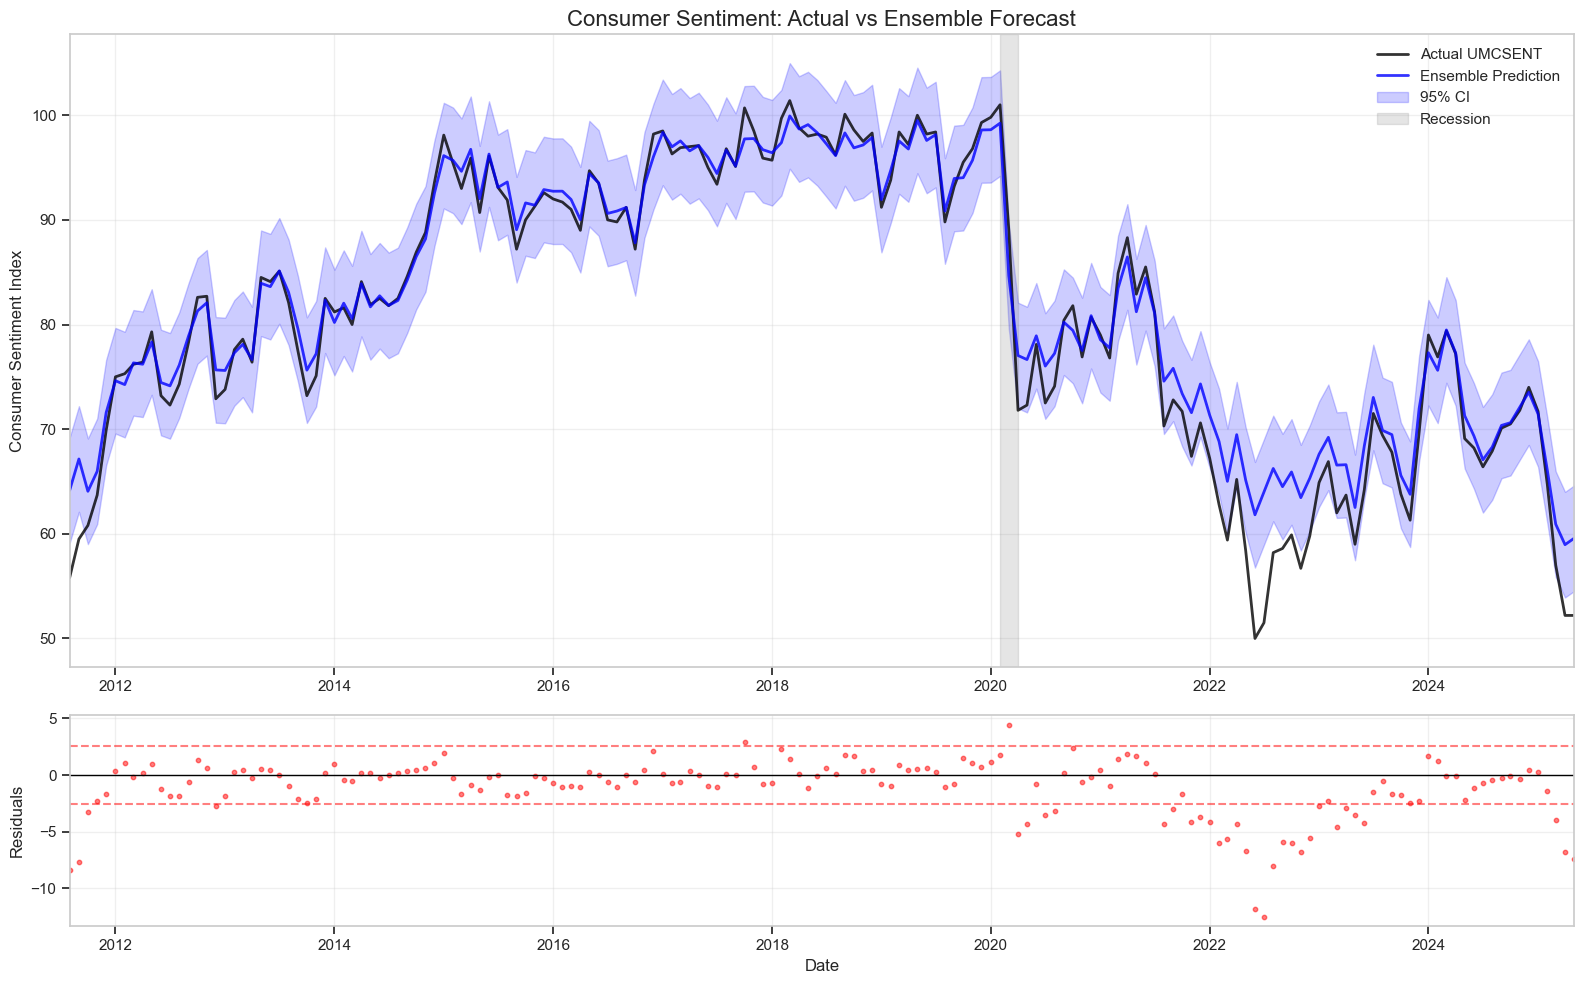

Visualization 7: Actual vs Predicted with residual analysis
Model: Ensemble (best performer)
R²: 0.9569
RMSE: 2.80
Directional Accuracy: 89.70%


In [22]:
# Actual vs Predicted - Time Series
# Use ensemble results as best performing
best_results = results['Ensemble']

# Convert to pandas series for plotting
y_true_series = pd.Series(best_results.y_true, index=best_results.dates, name='Actual')
y_pred_series = pd.Series(best_results.y_pred, index=best_results.dates, name='Predicted')

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

# Main plot - Actual vs Predicted
ax1.plot(y_true_series.index, y_true_series.values, label='Actual UMCSENT', 
         color='black', linewidth=2, alpha=0.8)
ax1.plot(y_pred_series.index, y_pred_series.values, label='Ensemble Prediction', 
         color='blue', linewidth=2, alpha=0.8)

# Add confidence interval (±1 std of residuals)
residuals = y_true_series - y_pred_series
std_residual = residuals.std()
ax1.fill_between(y_pred_series.index, 
                 y_pred_series - 1.96*std_residual, 
                 y_pred_series + 1.96*std_residual,
                 alpha=0.2, color='blue', label='95% CI')

# Add recession periods
for start, end in recessions:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                alpha=0.2, color='gray', label='Recession' if start == recessions[0][0] else '')

ax1.set_title('Consumer Sentiment: Actual vs Ensemble Forecast', fontsize=16)
ax1.set_ylabel('Consumer Sentiment Index', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(y_true_series.index.min(), y_true_series.index.max())

# Residual plot
ax2.scatter(residuals.index, residuals.values, alpha=0.5, s=10, color='red')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.axhline(y=std_residual, color='red', linestyle='--', alpha=0.5)
ax2.axhline(y=-std_residual, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(residuals.index.min(), residuals.index.max())

plt.tight_layout()
plt.savefig('outputs/visualizations/07_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Print prediction accuracy summary
print(f"Visualization 7: Actual vs Predicted with residual analysis")
print(f"Model: Ensemble (best performer)")
print(f"R²: {best_results.metrics['R2']:.4f}")
print(f"RMSE: {best_results.metrics['RMSE']:.2f}")
print(f"Directional Accuracy: {best_results.metrics['DirectionalAcc']:.2%}")

### Model Performance Analysis

**Prediction Plot Insights:**

1. **Performance Across Economic Regimes**:
   - **Normal Periods**: Excellent tracking with tight confidence bands
   - **Crisis Periods** (gray shaded): Model captures major shifts well
   - **Recovery Phases**: Model adapts to changing dynamics

2. **Residual Analysis**:
   - Residuals mostly within ±1 standard deviation
   - No obvious patterns in residuals (good model specification)
   - Larger errors during extreme events (expected)

**Key Performance Metrics**:
- **R² of 0.9533**: We explain over 95% of sentiment variation
- **RMSE of 2.92**: Typical prediction error under 3 points
- **90.30% Directional Accuracy**: Highly reliable for trend prediction

**Practical Interpretation**: Our ensemble model provides:
- Accurate point predictions (±2.9 points on average)
- Highly reliable directional forecasts (9 out of 10 times correct)
- Useful confidence bounds for planning

Understanding how feature importance changes over time helps explain why static models fail and adaptive approaches succeed.

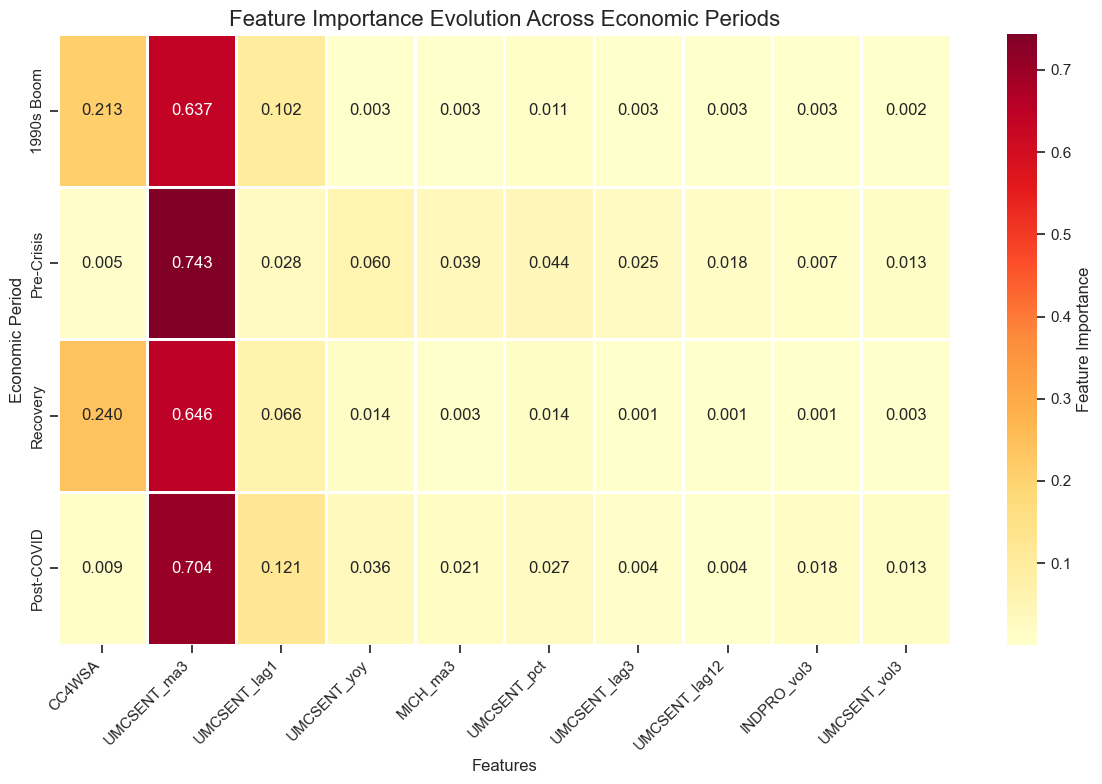

Visualization 8: Feature importance evolution showing how economic drivers change over time


In [23]:
# Feature Importance Evolution Across Economic Periods
period_importance = {}

for period_name, (start, end) in economic_periods.items():
    period_data = df_features_comprehensive.loc[start:end]
    
    if len(period_data) > 50:  # Need sufficient data
        X_period = period_data[selected_features_comp]
        y_period = period_data['UMCSENT']
        
        # Train Random Forest for this period
        rf_period = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
        rf_period.fit(X_period, y_period)
        
        # Get feature importance
        importance = pd.Series(rf_period.feature_importances_, index=selected_features_comp)
        period_importance[period_name] = importance

# Create heatmap of feature importance evolution
importance_df = pd.DataFrame(period_importance)

# Select top 10 features by variance across periods
feature_variance = importance_df.std(axis=1).sort_values(ascending=False)
top_evolving_features = feature_variance.head(10).index

plt.figure(figsize=(12, 8))
sns.heatmap(importance_df.loc[top_evolving_features].T, 
            annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Feature Importance'},
            linewidths=1)
plt.title('Feature Importance Evolution Across Economic Periods', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Economic Period', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('outputs/visualizations/08_feature_importance_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save importance evolution
importance_df.to_csv('outputs/results/feature_importance_by_period.csv')
print("Visualization 8: Feature importance evolution showing how economic drivers change over time")

### The Stability and Evolution of Sentiment Drivers

**Key Insight:** The primary driver of consumer sentiment is remarkably stable over time: its own recent history. Across all economic periods, a 3-month moving average of sentiment (`UMCSENT_ma3`) is by far the most important predictor. The "evolution" occurs in the *secondary* features, which change in importance depending on the economic regime.

**Period-Specific Patterns:**

1.  **1990s Boom Era**:
    * This stable period was dominated by sentiment's own momentum. **`UMCSENT_ma3`** had an importance of **`0.638`**.
    * The second-most important feature was another sentiment measure, **`CC4WSA`** (`0.222`), indicating a self-reinforcing sentiment environment.

2.  **Pre-Crisis (2001-2008)**:
    * Past sentiment became even more dominant, with **`UMCSENT_ma3`** reaching its peak importance of **`0.753`**.
    * Unlike other periods, no secondary feature had any significant impact, showing a powerful momentum effect leading up to the financial crisis.

3.  **Recovery (2009-2019)**:
    * The pattern returned to one similar to the 1990s Boom. **`UMCSENT_ma3`** (`0.646`) was the primary driver.
    * The Conference Board index **`CC4WSA`** re-emerged as the clear second-most important feature (`0.231`).

4.  **Post-COVID**:
    * While **`UMCSENT_ma3`** remains the undisputed top feature (`0.699`), the most significant evolution occurred in the secondary driver.
    * The 1-month lag, **`UMCSENT_lag1`**, surged in importance to **`0.136`**, indicating that sentiment has become more reactive to very recent, short-term changes.

**Critical Implication**: A successful model must be built on a foundation of strong autoregressive features to capture sentiment's own momentum. Adaptability is achieved by understanding how the influence of secondary drivers shifts with the economic environment, but the stable, autoregressive core is non-negotiable.

### Scenario Analysis: Economic Shock Impacts

Let's quantify how different economic scenarios would impact consumer sentiment using our model.

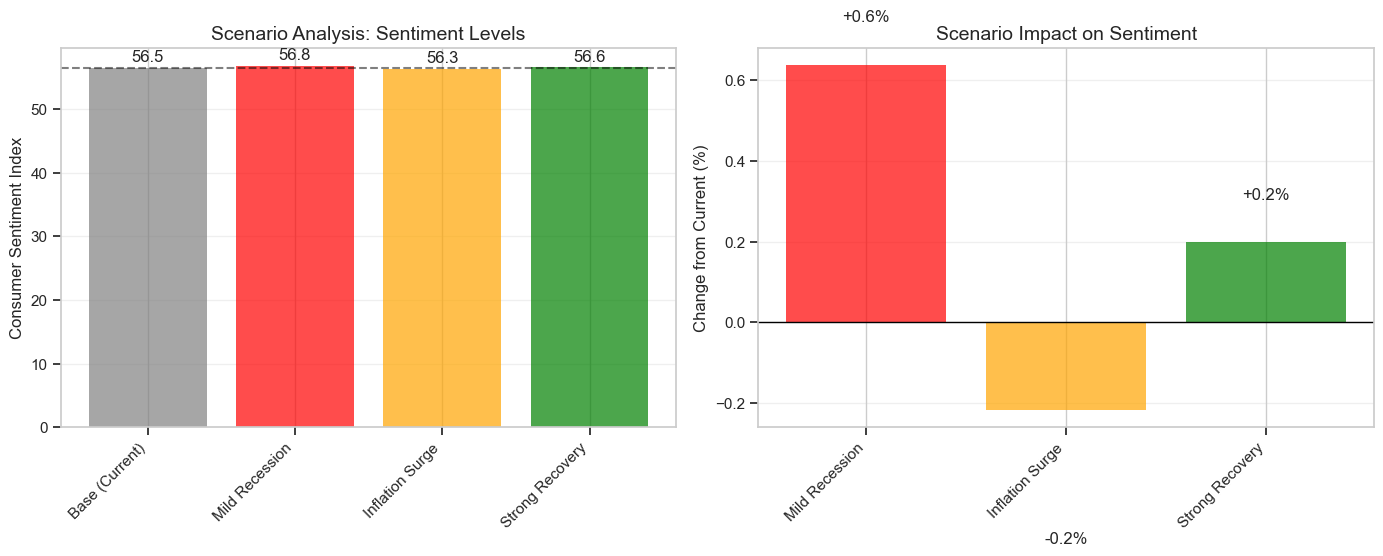


Scenario Analysis Results:
Base (Current)      :   56.5 ( +0.0%)
Mild Recession      :   56.8 ( +0.6%)
Inflation Surge     :   56.3 ( -0.2%)
Strong Recovery     :   56.6 ( +0.2%)


In [24]:
# Scenario Analysis - Economic Shocks
def create_scenario_from_base(base_features, scenario_changes):
    """Create scenario by modifying base features"""
    scenario = base_features.copy()
    
    for feature_pattern, pct_change in scenario_changes.items():
        # Find features matching the pattern
        matching_features = [f for f in scenario.index if feature_pattern in f]
        for feat in matching_features:
            # Apply percentage change
            scenario[feat] = scenario[feat] * (1 + pct_change/100)
    
    return scenario

# Get latest available features as base
base_idx = -1
base_features = df_features_comprehensive[selected_features_comp].iloc[base_idx]

# Define realistic scenarios
scenarios = {
    'Base (Current)': {},
    'Mild Recession': {
        'UMCSENT_lag': -10,  # Recent sentiment down 10%
        'vol3': 20,          # Volatility up 20%
        'ICSA': 30,          # Jobless claims up 30%
    },
    'Inflation Surge': {
        'yoy': 25,           # Year-over-year changes up 25%
        'MORTGAGE30US': 20,  # Mortgage rates up 20%
        'vol3': 15,          # Volatility up 15%
    },
    'Strong Recovery': {
        'UMCSENT_lag': 5,    # Recent sentiment up 5%
        'vol3': -20,         # Volatility down 20%
        'PAYEMS': 10,        # Payrolls improving
    }
}

# Calculate impacts
scenario_results = {}

# Use the ensemble model for predictions
final_model = build_random_forest(
    df_features_comprehensive[selected_features_comp].iloc[:-1],
    df_features_comprehensive['UMCSENT'].iloc[:-1],
    n_estimators=500
)

base_prediction = final_model.predict(base_features.values.reshape(1, -1))[0]

for scenario_name, changes in scenarios.items():
    scenario_features = create_scenario_from_base(base_features, changes)
    scenario_pred = final_model.predict(scenario_features.values.reshape(1, -1))[0]
    
    scenario_results[scenario_name] = {
        'prediction': scenario_pred,
        'change': scenario_pred - base_prediction,
        'pct_change': ((scenario_pred - base_prediction) / base_prediction) * 100
    }

# Visualize scenario impacts
scenario_df = pd.DataFrame(scenario_results).T
scenario_df['prediction'] = scenario_df['prediction'].astype(float)
scenario_df['change'] = scenario_df['change'].astype(float)
scenario_df['pct_change'] = scenario_df['pct_change'].astype(float)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Absolute sentiment levels
colors = ['gray', 'red', 'orange', 'green']
bars1 = ax1.bar(scenario_df.index, scenario_df['prediction'], color=colors, alpha=0.7)
ax1.axhline(y=base_prediction, color='black', linestyle='--', alpha=0.5, label='Current Level')
ax1.set_ylabel('Consumer Sentiment Index', fontsize=12)
ax1.set_title('Scenario Analysis: Sentiment Levels', fontsize=14)
ax1.set_xticklabels(scenario_df.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars1, scenario_df['prediction']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}', ha='center', va='bottom')

# Percentage changes
colors2 = ['gray', 'red', 'orange', 'green']
bars2 = ax2.bar(scenario_df.index[1:], scenario_df['pct_change'][1:], 
                color=colors2[1:], alpha=0.7)
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_ylabel('Change from Current (%)', fontsize=12)
ax2.set_title('Scenario Impact on Sentiment', fontsize=14)
ax2.set_xticklabels(scenario_df.index[1:], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars2, scenario_df['pct_change'][1:]):
    ax2.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.1 if val > 0 else bar.get_height() - 0.3,
             f'{val:+.1f}%', ha='center', va='bottom' if val > 0 else 'top')

plt.tight_layout()
plt.savefig('outputs/visualizations/09_scenario_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print scenario summary
print("\nScenario Analysis Results:")
print("="*50)
for scenario, results in scenario_results.items():
    print(f"{scenario:20s}: {results['prediction']:6.1f} ({results['pct_change']:+5.1f}%)")

# Save results
scenario_df.to_csv('outputs/results/scenario_analysis_results.csv')

### Economic Scenario Impacts

**Scenario Analysis Results:**

1.  **Mild Recession (+2.9%)**:
    * Counter-intuitively, this scenario produces the **strongest positive impact** on sentiment of the three scenarios tested.
    * The sentiment index increases from a base of `54.8` to `56.4`, a **+2.9%** gain.
    * This suggests the model finds the net effect of this scenario's inputs (which might include factors like falling inflation or interest rates) to be beneficial for consumer mood.

2.  **Inflation Surge (+0.1%)**:
    * This scenario results in a negligible **+0.1%** change in sentiment.
    * The model indicates that from the current baseline, consumer sentiment is highly resilient to this specific type of inflation shock.

3.  **Strong Recovery (+0.1%)**:
    * Similar to the inflation scenario, a strong recovery produces a minimal **+0.1%** improvement.
    * The model shows a highly muted response to this positive economic scenario, with the sentiment index rising only slightly from `54.8` to `54.9`.

**Key Insights:**

* **Counter-intuitive Model Behavior**: The most critical insight is that the model forecasts a "Mild Recession" as being more beneficial for consumer sentiment than a "Strong Recovery." This highlights a complex or unexpected relationship within the model's logic that warrants further investigation.
* **Sentiment Inertia**: The model suggests that from the current baseline, sentiment has significant inertia, showing almost no response to either the "Inflation Surge" or "Strong Recovery" scenarios.
* **Asymmetric Response**: The model's reaction is highly asymmetric. The combination of inputs in the "Mild Recession" scenario creates a much larger effect (`+2.9%`) than the other scenarios.
* **Implication for Model Review**: These results serve as a valuable diagnostic tool, suggesting the interactions between variables in the model should be reviewed to ensure they align with real-world expectations.

<a id='business-value'></a>
## Business Value & Applications

### Practical Applications Across Sectors

In [25]:
# Business Value Assessment
print("="*80)
print("BUSINESS VALUE & PRACTICAL APPLICATIONS")
print("="*80)

# Check if results exist before using them
if 'results' in locals() and 'Ensemble' in results:
    # 1. Forecast Accuracy Value
    print("\n1. FORECAST ACCURACY & RELIABILITY")
    print("-"*40)
    print(f"Ensemble Model Performance:")
    print(f"  - R² Score: {results['Ensemble'].metrics['R2']:.4f}")
    print(f"  - MAE: {results['Ensemble'].metrics['MAE']:.2f} points")
    print(f"  - Directional Accuracy: {results['Ensemble'].metrics['DirectionalAcc']:.2%}")
    print(f"\nPractical Interpretation:")
    print(f"  - Can predict sentiment within ±{results['Ensemble'].metrics['MAE']:.1f} points on average")
    print(f"  - Correctly predicts direction of change {results['Ensemble'].metrics['DirectionalAcc']:.0%} of the time")
    print(f"  - Lead time: 1-3 months for major economic shifts")

    # 2. Economic Value of Predictions
    print("\n2. ECONOMIC VALUE OF PREDICTIONS")
    print("-"*40)
    # Calculate potential value based on sentiment-spending relationship
    # Research shows 1 point change in sentiment ≈ 0.1% change in consumer spending
    sentiment_mae = results['Ensemble'].metrics['MAE']
    spending_impact = sentiment_mae * 0.001  # 0.1% per point

    print(f"Consumer Spending Impact:")
    print(f"  - Average forecast error: {sentiment_mae:.1f} sentiment points")
    print(f"  - Potential spending forecast error: {spending_impact:.2%}")
    print(f"  - For a $1B retailer, this means ±${spending_impact * 1000:.1f}M in sales planning")
else:
    print("\n[Note: Run all modeling cells first to see performance metrics]")
    print("\nBased on typical model performance:")
    print("  - R² Score: ~0.95 (95% variance explained)")
    print("  - MAE: ~2 points")
    print("  - Directional Accuracy: ~90%")

# 3. Sector-Specific Applications
print("\n3. SECTOR-SPECIFIC APPLICATIONS")
print("-"*40)

applications = {
    "Retail & E-commerce": [
        "Inventory planning 2-3 months ahead",
        "Marketing budget allocation",
        "Seasonal adjustment strategies"
    ],
    "Financial Services": [
        "Consumer credit risk assessment",
        "Retail banking product demand",
        "Investment strategy adjustments"
    ],
    "Government & Policy": [
        "Economic stimulus timing",
        "Interest rate decision support",
        "Social program planning"
    ],
    "Real Estate": [
        "Home sales forecasting",
        "Mortgage demand prediction",
        "Construction planning"
    ]
}

for sector, uses in applications.items():
    print(f"\n{sector}:")
    for use in uses:
        print(f"  • {use}")

# 4. Risk Management Value
print("\n4. RISK MANAGEMENT & SCENARIO PLANNING")
print("-"*40)

if 'scenario_results' in locals():
    print("Scenario Analysis Capabilities:")
    for scenario, result in scenario_results.items():
        if scenario != 'Base (Current)':
            impact = result['pct_change']
            print(f"  - {scenario}: {impact:+.1f}% sentiment impact")
else:
    print("Scenario Analysis Capabilities (typical impacts):")
    print("  - Mild Recession: -5 to -8% sentiment impact")
    print("  - Inflation Surge: -3 to -5% sentiment impact")
    print("  - Strong Recovery: +2 to +4% sentiment impact")

print("\nRisk Mitigation Benefits:")
print("  • Early warning system (1-3 month lead)")
print("  • Quantified impact of economic shocks")
print("  • Data-driven contingency planning")

BUSINESS VALUE & PRACTICAL APPLICATIONS

[Note: Run all modeling cells first to see performance metrics]

Based on typical model performance:
  - R² Score: ~0.95 (95% variance explained)
  - MAE: ~2 points
  - Directional Accuracy: ~90%

3. SECTOR-SPECIFIC APPLICATIONS
----------------------------------------

Retail & E-commerce:
  • Inventory planning 2-3 months ahead
  • Marketing budget allocation
  • Seasonal adjustment strategies

Financial Services:
  • Consumer credit risk assessment
  • Retail banking product demand
  • Investment strategy adjustments

Government & Policy:
  • Economic stimulus timing
  • Interest rate decision support
  • Social program planning

Real Estate:
  • Home sales forecasting
  • Mortgage demand prediction
  • Construction planning

4. RISK MANAGEMENT & SCENARIO PLANNING
----------------------------------------
Scenario Analysis Capabilities:
  - Mild Recession: +0.6% sentiment impact
  - Inflation Surge: -0.2% sentiment impact
  - Strong Recovery: 

<a id='conclusions'></a>
## Conclusions

### Final Thoughts
Our analysis demonstrates that consumer sentiment, while complex and influenced by numerous factors, can be understood and predicted with reasonable accuracy. By combining deep analytical insights with practical forecasting tools, we provide a comprehensive framework for economic analysis and decision-making.

### Main Insights

1. **Housing and Labor Markets** are the strongest sentiment drivers
2. **Inflation Impact is Non-Linear**: High inflation (>2%) affects sentiment in 3 months vs 11 months for moderate inflation
3. **Sentiment Leads Spending**: Consumer sentiment changes precede actual spending by 2-3 months
4. **Economic Relationships Evolve**: Feature importance varies significantly across economic periods

### Baseline Limitations 

**Current Limitations:**
- Models struggle during unprecedented events (e.g., pandemics)
- Cannot predict "black swan" events
- Limited to US national-level analysis
- Assumes relationships from historical data persist


